# Basic Controls for Sex
This section of the notebook is dedicated to:
1. Cleaning the data. 
2. Examining the mismatch in years between corruption and BMI data
3. Constructing a basic control for the proportion of men and women in leadership.

In [34]:
# imports & function declarations
import pandas as pd
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt

def regress(dep: pd.Series, indep):
    '''Wrapper for statsmodels regression. Takes in a dependent variable and one or more independent ones'''
    return sm.OLS(
        dep, sm.add_constant(
            indep)
    ).fit()
    

def simple_scatter(x: pd.Series, y: pd.Series, xlabel='', ylabel='', title='', regression_line=True):
    '''Wrapper for matplotlib scatter plot'''
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    if regression_line:
        m, b = np.polyfit(x, y, 1)
        ax.plot(x, m*x+b, color='orange')
        
    countries = x.index.values
    plt.show()
    

def annotate_scatter(x:pd.Series, y:pd.Series, annot: dict, x_adjust=0, y_adjust=0, xlabel='', ylabel='', title=''):
    '''Wrapper for matplotlib scatter plot but with annotations'''
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.set_title(title)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*x+b, color='orange')
    for i, txt in enumerate(x):
        ax.annotate(annot[i], (x[i] + x_adjust, y[i] + y_adjust))
    plt.show()
    

def regress_filtered(col: str):
    '''Regresses BMI on one measure of corruption (col)'''
    index = corruption[col]
    missing_filter = index.notna()
    filtered_bmi = bmis[missing_filter]['median_bmi']
    filtered_index = index[missing_filter]
    return regress(filtered_index, filtered_bmi).summary()


def plot_filtered(col: str, ylabel: str):
    '''Plots BMI against one measure of corruption (col)'''
    index = corruption[col]
    missing_filter = index.notna()
    filtered_bmi = bmis[missing_filter]['median_bmi']
    filtered_index = index[missing_filter]
    simple_scatter(filtered_bmi, filtered_index,
                   'Median estmated ministers\' body-mass index',
                   ylabel)
    

ABBREVIATIONS = {
    'Estonia': 'EST',
    'Lithuania': 'LTU',
    'Latvia': 'LVA',
    'Georgia': 'GEO',
    'Armenia': 'ARM',
    'Russia': 'RUS',
    'Moldova': 'MDA',
    'Belarus': 'BLR',
    'Kyrgyzstan': 'KGZ',
    'Azerbaijan': 'AZE',
    'Tajikistan': 'TJK',
    'Kazakhstan': 'KAZ',
    'Ukraine': 'UKR',
    'Turkmenistan': 'TKM',
    'Uzbekistan': 'UZB'
}

def abbrviate_countries(arr):
    '''Transforms an array of countries into their abbreviated forms'''
    return [ABBREVIATIONS[name] for name in arr]


In [35]:
# import minister age and sex data

ministers = pd.read_csv('./ministers.csv', encoding="utf-16")
ministers.head()

,name,sex,age,country,image
0,Karen Karapetyan,M,53.0,Armenia,45bbf60d9a78c802.jpg
1,Vigen Sargsyan,M,42.0,Armenia,7cd0c6d7bb93035.jpg
2,Vache Gabrielyan,M,48.0,Armenia,ac879073ab927981.jpg
3,Suren Karayan,M,44.0,Armenia,a2ba3f513063c0b.jpg
4,Ignati Arakelyan,M,45.0,Armenia,8676f84b0cbeec53.jpg


In [36]:
# clean minister age and sex data and find sex ratios
def filter_sex(sex: str) -> pd.Series:
    '''Filters out ministers by sex'''
    only_sex = ministers[ministers['sex'] == sex]
    return only_sex.groupby('country').count()['sex']
    
only_men = filter_sex('M')
only_women = filter_sex('F')

# calculate sex ratio and add to dataframe
sex_ratio = pd.DataFrame({'men': only_men, 'women': only_women}).fillna(0)
sex_ratio['women'] = sex_ratio['women'].astype(int)
sex_ratio['total'] = sex_ratio['men'] + sex_ratio['women']

sex_ratio['ratio'] = sex_ratio['men'] / sex_ratio['total']
sex_ratio.columns

Index(['men', 'women', 'total', 'ratio'], dtype='object')

In [37]:
# import and clean WHO BMI data
bmi = pd.read_csv('./WHO-BMI.csv', encoding="utf-8", index_col=0)

def clean_bmi(row: pd.Series) -> pd.Series:
    '''Cleans up and numberfies the numerical strings in a row. e.g. "26.5 [26.0-27.1]" to 26.5'''
    replaced = row.str.replace(r' \[\d{1,2}.?\d{1,2}-\d{1,2}.?\d{1,2}]', '', regex=True)
    return replaced.astype(float)


for r in bmi.columns:
    bmi[r] = clean_bmi(bmi[r])
    
# bmi data is easier to deal with reversed
bmi = bmi.iloc[:, ::-1]

# gets only first columns i.e. 2017 data
bmi_2017 = bmi[['2016Both sexes', '2016Male', '2016Female']]
bmi_2017.head(15)


,2016Both sexes,2016Male,2016Female
Country,,,
Armenia,26.5,25.6,27.5
Azerbaijan,27.0,26.1,27.9
Belarus,27.2,26.7,27.7
Estonia,27.0,27.2,26.8
Georgia,28.1,27.7,28.4
Kazakhstan,26.4,26.2,26.6
Kyrgyzstan,26.2,25.6,26.8
Latvia,27.4,27.3,27.5
Lithuania,27.0,27.3,26.8


## Graphing BMIs over time
There was some concern in the review process that using slightly out of date BMI data would be a problem for my results. The corruption data is all from 2017, while the latest WHO BMI data is from 2016. However, these charts illustrate two things.
1. BMI is on a steady, and within the past few years, comparable upswing
2. BMI increases very slowly over time, so 2016's values are likely to be very similar to 2017's.

Text(0, 0.5, 'Mean Female BMI (WHO)')

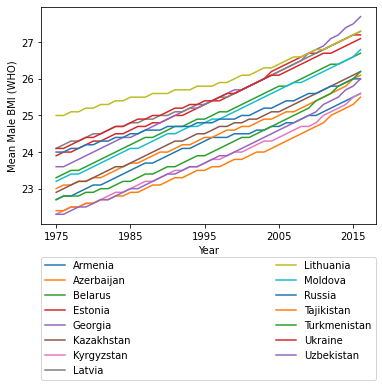

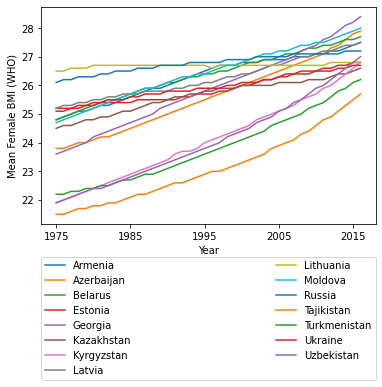

In [38]:
# graph male and female BMIs over time
male_cols = [el for el in bmi.columns if "Male" in el]
female_cols = [el for el in bmi.columns if "Female" in el]
both_cols = [el for el in bmi.columns if "Both" in el]

def strip_to_year(col):
    return col[:4]

male_bmi_time = bmi.loc[:,male_cols].rename(strip_to_year, axis=1).T
female_bmi_time = bmi.loc[:, female_cols].rename(
    strip_to_year, axis=1).T
m_plot = male_bmi_time.plot(legend=False)
m_plot.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2,
                 ncol=2, mode="expand", borderaxespad=0)
m_plot.set_xlabel('Year')
m_plot.set_ylabel('Mean Male BMI (WHO)')

f_plot = female_bmi_time.plot(legend=False)
f_plot.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2,
              ncol=2, mode="expand", borderaxespad=0)
f_plot.set_xlabel('Year')
f_plot.set_ylabel('Mean Female BMI (WHO)')


In [39]:
# merge bmi data and minister data
bmi_with_ministers = pd.merge(
    sex_ratio, bmi_2017, left_index=True, right_on='Country')
bmi_with_ministers = bmi_with_ministers.rename({'men': 'men_in_gov', 'women': 'women_in_gov', 'total': 'minister_count', 'ratio': 'minister_sex_ratio', 'Country': 'country', '2016Both sexes': 'both_sexes_bmi', '2016Male': 'male_bmi', '2016Female': 'female_bmi'}, axis = 1)
bmi_with_ministers.head(15)

,men_in_gov,women_in_gov,minister_count,minister_sex_ratio,both_sexes_bmi,male_bmi,female_bmi
Country,,,,,,,
Armenia,18,1,19,0.947368,26.5,25.6,27.5
Azerbaijan,26,0,26,1.000000,27.0,26.1,27.9
Belarus,28,2,30,0.933333,27.2,26.7,27.7
Estonia,11,4,15,0.733333,27.0,27.2,26.8
Georgia,19,2,21,0.904762,28.1,27.7,28.4
Kazakhstan,18,1,19,0.947368,26.4,26.2,26.6
Kyrgyzstan,14,3,17,0.823529,26.2,25.6,26.8
Latvia,11,3,14,0.785714,27.4,27.3,27.5
Lithuania,12,3,15,0.800000,27.0,27.3,26.8


In [40]:
# puts median minister data (taken from Blavatskyy's paper) into dataframe with minister and BMI data
median_ministers = {
    'Estonia': 28.7,
    'Lithuania': 30.3,
    'Latvia': 30.7,
    'Georgia': 30.9,
    'Armenia': 32.1,
    'Russia': 32.5,
    'Moldova': 32.7,
    'Belarus': 32.9,
    'Kyrgyzstan': 33.3,
    'Azerbaijan': 33.3,
    'Tajikistan': 33.6,
    'Kazakhstan': 33.8,
    'Ukraine': 34.4,
    'Turkmenistan': 34.7,
    'Uzbekistan': 35.5
}

bmi_with_ministers['median_minister_bmi'] = bmi_with_ministers.index.map(median_ministers)
bmi_with_ministers.head(15)


,men_in_gov,women_in_gov,minister_count,minister_sex_ratio,both_sexes_bmi,male_bmi,female_bmi,median_minister_bmi
Country,,,,,,,,
Armenia,18,1,19,0.947368,26.5,25.6,27.5,32.1
Azerbaijan,26,0,26,1.000000,27.0,26.1,27.9,33.3
Belarus,28,2,30,0.933333,27.2,26.7,27.7,32.9
Estonia,11,4,15,0.733333,27.0,27.2,26.8,28.7
Georgia,19,2,21,0.904762,28.1,27.7,28.4,30.9
Kazakhstan,18,1,19,0.947368,26.4,26.2,26.6,33.8
Kyrgyzstan,14,3,17,0.823529,26.2,25.6,26.8,33.3
Latvia,11,3,14,0.785714,27.4,27.3,27.5,30.7
Lithuania,12,3,15,0.800000,27.0,27.3,26.8,30.3


In [41]:
# creates sex-adjusted BMI by weighing the proportion of men and women in leadership
men_ratio = bmi_with_ministers['minister_sex_ratio']
women_ratio = 1 - men_ratio
men_bmi = bmi_with_ministers['male_bmi']
women_bmi = bmi_with_ministers['female_bmi']
total_num = bmi_with_ministers['minister_count']
adjusted_bmi = ((men_ratio * men_bmi) + (women_ratio * women_bmi))
bmi_with_ministers['adjusted_bmi'] = adjusted_bmi

bmi_with_ministers.head(15)

,men_in_gov,women_in_gov,minister_count,minister_sex_ratio,both_sexes_bmi,male_bmi,female_bmi,median_minister_bmi,adjusted_bmi
Country,,,,,,,,,
Armenia,18,1,19,0.947368,26.5,25.6,27.5,32.1,25.700000
Azerbaijan,26,0,26,1.000000,27.0,26.1,27.9,33.3,26.100000
Belarus,28,2,30,0.933333,27.2,26.7,27.7,32.9,26.766667
Estonia,11,4,15,0.733333,27.0,27.2,26.8,28.7,27.093333
Georgia,19,2,21,0.904762,28.1,27.7,28.4,30.9,27.766667
Kazakhstan,18,1,19,0.947368,26.4,26.2,26.6,33.8,26.221053
Kyrgyzstan,14,3,17,0.823529,26.2,25.6,26.8,33.3,25.811765
Latvia,11,3,14,0.785714,27.4,27.3,27.5,30.7,27.342857
Lithuania,12,3,15,0.800000,27.0,27.3,26.8,30.3,27.200000


In [42]:
# regresses adjusted BMI on minister BMI
adjusted_minister_country_relation = regress(adjusted_bmi, bmi_with_ministers['median_minister_bmi'])

adjusted_minister_country_relation.summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.273
Method:                 Least Squares   F-statistic:                     6.248
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0266
Time:                        16:12:14   Log-Likelihood:                -12.058
No. Observations:                  15   AIC:                             28.12
Df Residuals:                      13   BIC:                             29.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  33.4505      2.773     12.065      0.000      27.461      39.440
median_minister_bmi    -0.2121      0.085     -2.500      0.027      -0.395      -0.029
==============================================================================
Omnibus:                        0.409   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.815   Jarque-Bera (JB):                0.503
Skew:                          -0.053   Prob(JB):                        0.778
Kurtosis:                       2.109   Cond. No.                         605.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
# regresses unadjusted country BMI on minister BMI
unadjusted_minister_country_relation = regress(
    bmi_with_ministers['both_sexes_bmi'],
    bmi_with_ministers['median_minister_bmi']
    )

unadjusted_minister_country_relation.summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         both_sexes_bmi   R-squared:                       0.273
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     4.885
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0456
Time:                        16:12:19   Log-Likelihood:                -10.960
No. Observations:                  15   AIC:                             25.92
Df Residuals:                      13   BIC:                             27.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  32.4937      2.577     12.610      0.000      26.927      38.061
median_minister_bmi    -0.1743      0.079     -2.210      0.046      -0.345      -0.004
==============================================================================
Omnibus:                        0.041   Durbin-Watson:                   2.377
Prob(Omnibus):                  0.980   Jarque-Bera (JB):                0.099
Skew:                          -0.023   Prob(JB):                        0.951
Kurtosis:                       2.604   Cond. No.                         605.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

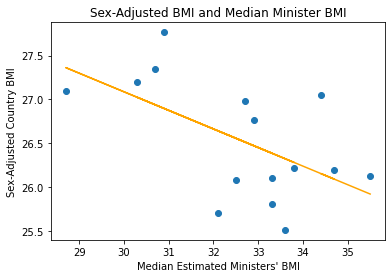

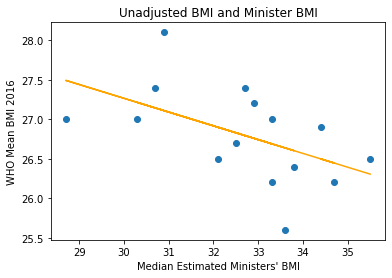

In [44]:
# plots adjusted and unadjusted BMI on minister BMI

simple_scatter(
    bmi_with_ministers['median_minister_bmi'], 
    adjusted_bmi, 
    'Median Estimated Ministers\' BMI', 
    'Sex-Adjusted Country BMI', 
    'Sex-Adjusted BMI and Median Minister BMI'
    )

simple_scatter(
    bmi_with_ministers['median_minister_bmi'],
    bmi_with_ministers['both_sexes_bmi'],
    'Median Estimated Ministers\' BMI',
    'WHO Mean BMI 2016',
    'Unadjusted BMI and Minister BMI'
    )


In [45]:
# finds difference between mean male and female BMIs in each country
bmi_diff = bmi_with_ministers['male_bmi'] - bmi_with_ministers['female_bmi']
print(bmi_diff.mean())
print(bmi_diff)

-0.6333333333333329
Country
Armenia        -1.9
Azerbaijan     -1.8
Belarus        -1.0
Estonia         0.4
Georgia        -0.7
Kazakhstan     -0.4
Kyrgyzstan     -1.2
Latvia         -0.2
Lithuania       0.5
Moldova        -1.2
Russia         -1.2
Tajikistan     -0.2
Turkmenistan    0.0
Ukraine         0.4
Uzbekistan     -1.0
dtype: float64


# Basic Controls for Age
This section is dedicated to controlling the data for the age of the ministers

In [46]:
# finds mean and median age of ministers in each country
# too many Tajik ministers missing ages to use country's data
ministers_age = ministers[ministers['country'] != 'Tajikistan']
ministers_age = ministers_age[ministers_age['age'].notna()]
grouped_ministers_age = ministers_age.groupby('country')
mean_age = grouped_ministers_age['age'].mean()
median_age = grouped_ministers_age['age'].median()

print(mean_age, median_age)

country
Armenia         49.421053
Azerbaijan      61.160000
Belarus         54.115385
Estonia         46.666667
Georgia         43.000000
Kazakhstan      49.315789
Kyrgyzstan      54.000000
Latvia          50.071429
Lithuania       45.615385
Moldova         45.833333
Russia          51.870968
Turkmenistan    52.444444
Ukraine         47.652174
Uzbekistan      54.705882
Name: age, dtype: float64 country
Armenia         49.0
Azerbaijan      61.0
Belarus         54.0
Estonia         45.0
Georgia         42.5
Kazakhstan      52.0
Kyrgyzstan      52.0
Latvia          49.5
Lithuania       47.0
Moldova         44.0
Russia          52.0
Turkmenistan    51.0
Ukraine         49.0
Uzbekistan      55.0
Name: age, dtype: float64


In [47]:
# creates dataframe of age data

# from UN World Population Prospects 2015
ages_2015 = {
    'Azerbaijan': 33.8,
    'Armenia': 30.3,
    'Georgia': 37.7,
    'Kazakhstan': 29.4,
    'Kyrgyzstan': 25.1,
    # 'Tajikistan': 22.0,
    'Turkmenistan': 25.6,
    'Uzbekistan': 26.2,
    'Belarus': 39.5,
    'Moldova': 35.6,
    'Russia': 38.6,
    'Ukraine': 40.0,
    'Estonia': 41.6,
    'Latvia': 42.6,
    'Lithuania': 42.7,
}

country_ages = pd.Series(ages_2015)
age_data = pd.concat([country_ages, mean_age, median_age], axis=1)
age_data.set_axis(['mean_country_age', 'mean_minister_age', 'median_minister_age'], axis=1, inplace=True)
age_data

,mean_country_age,mean_minister_age,median_minister_age
Azerbaijan,33.8,61.160000,61.0
Armenia,30.3,49.421053,49.0
Georgia,37.7,43.000000,42.5
Kazakhstan,29.4,49.315789,52.0
Kyrgyzstan,25.1,54.000000,52.0
Turkmenistan,25.6,52.444444,51.0
Uzbekistan,26.2,54.705882,55.0
Belarus,39.5,54.115385,54.0
Moldova,35.6,45.833333,44.0
Russia,38.6,51.870968,52.0


Country
Armenia         32.1
Azerbaijan      33.3
Belarus         32.9
Estonia         28.7
Georgia         30.9
Kazakhstan      33.8
Kyrgyzstan      33.3
Latvia          30.7
Lithuania       30.3
Moldova         32.7
Russia          32.5
Turkmenistan    34.7
Ukraine         34.4
Uzbekistan      35.5
Name: median_minister_bmi, dtype: float64
Azerbaijan      61.160000
Armenia         49.421053
Georgia         43.000000
Kazakhstan      49.315789
Kyrgyzstan      54.000000
Turkmenistan    52.444444
Uzbekistan      54.705882
Belarus         54.115385
Moldova         45.833333
Russia          51.870968
Ukraine         47.652174
Estonia         46.666667
Latvia          50.071429
Lithuania       45.615385
Name: mean_minister_age, dtype: float64


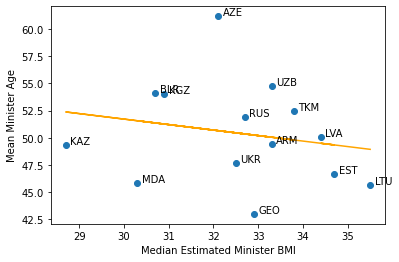

In [48]:
# compare politicians BMI and ages
med_minister_bmi = bmi_with_ministers.drop('Tajikistan')
print(med_minister_bmi.median_minister_bmi)
print(age_data.mean_minister_age)

annotate_scatter(
    med_minister_bmi.median_minister_bmi,
    age_data.mean_minister_age,
    abbrviate_countries(age_data['mean_minister_age'].index.values),
    0.1, 0.1, 'Median Estimated Minister BMI', 'Mean Minister Age'
    )


In [60]:
regress(age_data['mean_minister_age'].sort_index(), med_minister_bmi.median_minister_bmi.sort_index()).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_minister_age   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     4.543
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0544
Time:                        16:17:56   Log-Likelihood:                -38.825
No. Observations:                  14   AIC:                             81.65
Df Residuals:                      12   BIC:                             82.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   7.5213     20.158      0.373      0.716     -36.400      51.443
median_minister_bmi     1.3176      0.618      2.131      0.054      -0.029       2.665
==============================================================================
Omnibus:                        3.521   Durbin-Watson:                   1.653
Prob(Omnibus):                  0.172   Jarque-Bera (JB):                1.379
Skew:                           0.709   Prob(JB):                        0.502
Kurtosis:                       3.594   Cond. No.                         588.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [61]:
# regresses mean minister age on mean country age
mean_age_relationship = regress(age_data['mean_minister_age'], age_data['mean_country_age'])
mean_age_relationship.summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      mean_minister_age   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.123
Method:                 Least Squares   F-statistic:                     2.822
Date:                Tue, 22 Feb 2022   Prob (F-statistic):              0.119
Time:                        16:18:23   Log-Likelihood:                -39.594
No. Observations:                  14   AIC:                             83.19
Df Residuals:                      12   BIC:                             84.47
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               61.5238      6.714      9.163      0.000      46.894      76.153
mean_country_age    -0.3181      0.189     -1.680      0.119      -0.731       0.094
==============================================================================
Omnibus:                        4.944   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                2.250
Skew:                           0.906   Prob(JB):                        0.325
Kurtosis:                       3.755   Cond. No.                         202.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

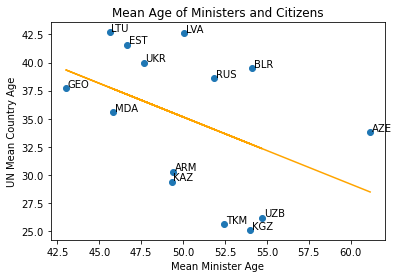

In [65]:
# makes scatter plot of minister age and mean country age
annotate_scatter(age_data['mean_minister_age'], 
                 age_data['mean_country_age'],
                 abbrviate_countries(age_data['mean_country_age'].index.values),
                 0.1,0.1,
                 'Mean Minister Age', 'UN Mean Country Age', 'Mean Age of Ministers and Citizens')


In [67]:
corruption = pd.read_csv('corruption.csv').set_index('country')
corruption.drop('Tajikistan', inplace=True)
corruption

,control_of_corruption,corruption perception index,basel anti money laundering,IDEA absence of corruption,Index of public integrity
country,,,,,
Armenia,-0.56,35,4.44,0.323753,NaN
Azerbaijan,-0.89,31,4.77,0.121495,6.227309
Belarus,-0.26,44,NaN,0.482308,NaN
Estonia,1.25,71,2.73,0.785597,8.877991
Georgia,0.74,56,5.28,0.651742,7.179274
Kazakhstan,-0.82,31,6.35,0.305049,5.627002
Kyrgyzstan,-1.06,29,6.24,0.225880,5.525407
Latvia,0.56,58,3.64,0.659737,7.912312
Lithuania,0.54,59,3.67,0.669400,7.688306


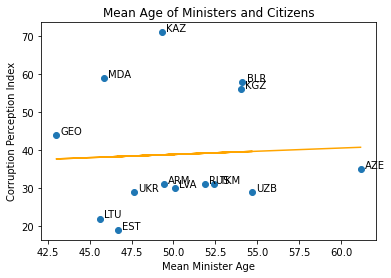

In [68]:
annotate_scatter(age_data['mean_minister_age'],
                 corruption['corruption perception index'],
                 abbrviate_countries(age_data['mean_country_age'].index.values),
                 0.25,0.25,
                 'Mean Minister Age', 'Corruption Perception Index', 'Mean Age of Ministers and Citizens')


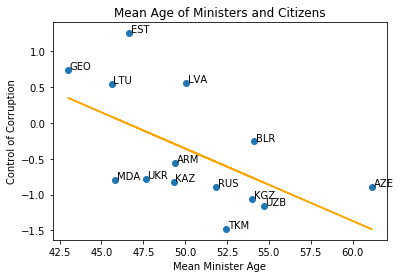

In [24]:
annotate_scatter(age_data['mean_minister_age'],
                 corruption['control_of_corruption'],
                 abbrviate_countries(age_data['mean_country_age'].index.values),
                 0.1,0.01,
                 'Mean Minister Age', 'Control of Corruption', 'Mean Age of Ministers and Citizens')


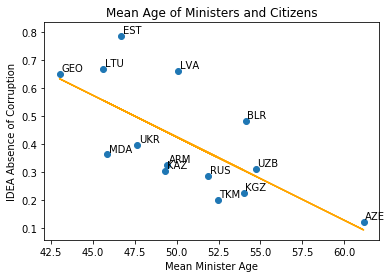

In [25]:
annotate_scatter(age_data['mean_minister_age'],
                 corruption['IDEA absence of corruption'],
                 abbrviate_countries(
                     age_data['mean_country_age'].index.values),
                 0.1, 0.01,
                 'Mean Minister Age', 'IDEA Absence of Corruption', 'Mean Age of Ministers and Citizens')


In [70]:
regress(corruption['corruption perception index'].sort_index(),
        age_data['mean_minister_age'].sort_index()).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.269
Model:                                     OLS   Adj. R-squared:                  0.208
Method:                          Least Squares   F-statistic:                     4.424
Date:                         Tue, 22 Feb 2022   Prob (F-statistic):             0.0572
Time:                                 16:31:52   Log-Likelihood:                -55.858
No. Observations:                           14   AIC:                             115.7
Df Residuals:                               12   BIC:                             117.0
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               126.9416     42.016      3.021      0.011      35.397     218.486
mean_minister_age    -1.7456      0.830     -2.103      0.057      -3.554       0.063
==============================================================================
Omnibus:                        1.720   Durbin-Watson:                   1.102
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                1.144
Skew:                           0.443   Prob(JB):                        0.565
Kurtosis:                       1.917   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [72]:
regress(
    corruption['control_of_corruption'].sort_index(), 
    age_data['mean_minister_age'].sort_index()
    ).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.328
Model:                               OLS   Adj. R-squared:                  0.272
Method:                    Least Squares   F-statistic:                     5.853
Date:                   Tue, 22 Feb 2022   Prob (F-statistic):             0.0324
Time:                           16:32:07   Log-Likelihood:                -14.002
No. Observations:                     14   AIC:                             32.00
Df Residuals:                         12   BIC:                             33.28
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.6917      2.113      2.220      0.046       0.087       9.297
mean_minister_age    -0.1010      0.042     -2.419      0.032      -0.192      -0.010
==============================================================================
Omnibus:                        1.451   Durbin-Watson:                   1.181
Prob(Omnibus):                  0.484   Jarque-Bera (JB):                0.994
Skew:                           0.373   Prob(JB):                        0.608
Kurtosis:                       1.928   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [73]:
regress(
    corruption['IDEA absence of corruption'].sort_index(),
    age_data['mean_minister_age'].sort_index()
).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.472
Model:                                    OLS   Adj. R-squared:                  0.428
Method:                         Least Squares   F-statistic:                     10.74
Date:                        Tue, 22 Feb 2022   Prob (F-statistic):            0.00662
Time:                                16:32:14   Log-Likelihood:                 7.3694
No. Observations:                          14   AIC:                            -10.74
Df Residuals:                              12   BIC:                            -9.461
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.9117      0.459      4.163      0.001       0.911       2.912
mean_minister_age    -0.0297      0.009     -3.277      0.007      -0.049      -0.010
==============================================================================
Omnibus:                        1.821   Durbin-Watson:                   1.322
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.279
Skew:                           0.532   Prob(JB):                        0.528
Kurtosis:                       1.970   Cond. No.                         564.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Reproducibility
This section is dedicated to reproducing Blavatskyy's results with his method

In [30]:
# get BMI of each minister -- commented out because it takes forever to run
# from bmipredictor import BMIPredictor
# bmi_predictor = BMIPredictor()
# # this is a test prediction
# # bmi_predictor.predict(
# #     'http://npg.si.edu/sites/default/files/blog_obama_martin_schoeller.jpg')

# estimated_bmi = ministers['image'].apply(lambda img : bmi_predictor.predict('./2017-images/' + img))
# estimated_bmi.head(20)

# # save BMI to CSV so we don't need to do ML over and over
# ministers['estimated_bmi'] = estimated_bmi
# ministers.to_csv('ministers2.csv')


In [76]:
estimated_ministers = pd.read_csv('ministers2.csv')
# remove buggy extra index col
estimated_ministers = estimated_ministers[['name', 'age', 'sex', 'country', 'image', 'estimated_bmi']]
median_bmi = estimated_ministers[['country', 'estimated_bmi']].groupby('country').median().rename({'estimated_bmi': 'median_bmi'}, axis=1)
mean_bmis = estimated_ministers[['country', 'estimated_bmi']].groupby('country').mean().rename({'estimated_bmi': 'mean_bmi'}, axis=1)

bmis = pd.concat([median_bmi, mean_bmis], axis = 1)
bmis['reported_median_bmis'] = pd.Series(median_ministers)

bmis[['median_bmi', 'mean_bmi', 'reported_median_bmis']].sort_values('reported_median_bmis').round(1)

,median_bmi,mean_bmi,reported_median_bmis
country,,,
Estonia,28.8,30.4,28.7
Lithuania,30.3,31.8,30.3
Latvia,30.7,31.2,30.7
Georgia,31.0,32.2,30.9
Armenia,32.2,31.7,32.1
Russia,32.5,32.5,32.5
Moldova,32.8,33.2,32.7
Belarus,32.8,33.5,32.9
Azerbaijan,33.3,32.9,33.3


In [77]:
corruption = pd.read_csv('corruption.csv').set_index('country')
corruption

,control_of_corruption,corruption perception index,basel anti money laundering,IDEA absence of corruption,Index of public integrity
country,,,,,
Armenia,-0.56,35,4.44,0.323753,NaN
Azerbaijan,-0.89,31,4.77,0.121495,6.227309
Belarus,-0.26,44,NaN,0.482308,NaN
Estonia,1.25,71,2.73,0.785597,8.877991
Georgia,0.74,56,5.28,0.651742,7.179274
Kazakhstan,-0.82,31,6.35,0.305049,5.627002
Kyrgyzstan,-1.06,29,6.24,0.225880,5.525407
Latvia,0.56,58,3.64,0.659737,7.912312
Lithuania,0.54,59,3.67,0.669400,7.688306


In [78]:
regress_filtered('control_of_corruption')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.835
Model:                               OLS   Adj. R-squared:                  0.822
Method:                    Least Squares   F-statistic:                     65.63
Date:                   Tue, 22 Feb 2022   Prob (F-statistic):           1.95e-06
Time:                           16:33:59   Log-Likelihood:                -4.6074
No. Observations:                     15   AIC:                             13.21
Df Residuals:                         13   BIC:                             14.63
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         13.3953      1.713      7.820      0.000       9.695      17.096
median_bmi    -0.4244      0.052     -8.101      0.000      -0.538      -0.311
==============================================================================
Omnibus:                        1.719   Durbin-Watson:                   1.012
Prob(Omnibus):                  0.423   Jarque-Bera (JB):                0.906
Skew:                           0.114   Prob(JB):                        0.636
Kurtosis:                       1.818   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

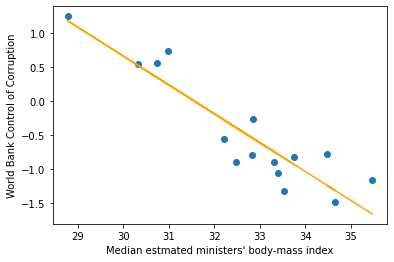

In [79]:
plot_filtered('control_of_corruption', 'World Bank Control of Corruption')

In [80]:
regress_filtered('corruption perception index')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.860
Model:                                     OLS   Adj. R-squared:                  0.850
Method:                          Least Squares   F-statistic:                     80.03
Date:                         Tue, 22 Feb 2022   Prob (F-statistic):           6.45e-07
Time:                                 16:34:17   Log-Likelihood:                -47.581
No. Observations:                           15   AIC:                             99.16
Df Residuals:                               13   BIC:                             100.6
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        306.2530     30.059     10.189      0.000     241.315     371.191
median_bmi    -8.2239      0.919     -8.946      0.000     -10.210      -6.238
==============================================================================
Omnibus:                        1.388   Durbin-Watson:                   0.934
Prob(Omnibus):                  0.500   Jarque-Bera (JB):                0.934
Skew:                          -0.295   Prob(JB):                        0.627
Kurtosis:                       1.929   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

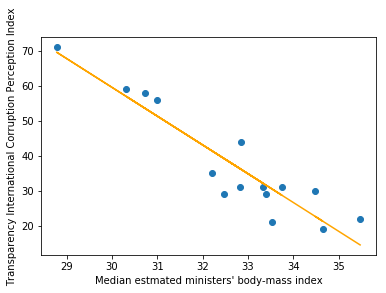

In [ ]:
plot_filtered('corruption perception index', ylabel='Transparency International Corruption Perception Index')

In [81]:
regress_filtered('basel anti money laundering')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     basel anti money laundering   R-squared:                       0.612
Model:                                     OLS   Adj. R-squared:                  0.577
Method:                          Least Squares   F-statistic:                     17.38
Date:                         Tue, 22 Feb 2022   Prob (F-statistic):            0.00157
Time:                                 16:34:21   Log-Likelihood:                -16.746
No. Observations:                           13   AIC:                             37.49
Df Residuals:                               11   BIC:                             38.62
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.8399      4.839     -3.066      0.011     -25.492      -4.188
median_bmi     0.6202      0.149      4.169      0.002       0.293       0.948
==============================================================================
Omnibus:                        7.489   Durbin-Watson:                   1.440
Prob(Omnibus):                  0.024   Jarque-Bera (JB):                3.661
Skew:                           1.133   Prob(JB):                        0.160
Kurtosis:                       4.276   Cond. No.                         596.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

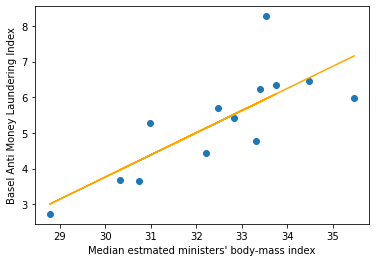

In [82]:
plot_filtered('basel anti money laundering', ylabel='Basel Anti Money Laundering Index')

In [83]:
regress_filtered('IDEA absence of corruption')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.653
Model:                                    OLS   Adj. R-squared:                  0.627
Method:                         Least Squares   F-statistic:                     24.51
Date:                        Tue, 22 Feb 2022   Prob (F-statistic):           0.000265
Time:                                16:34:33   Log-Likelihood:                 10.497
No. Observations:                          15   AIC:                            -16.99
Df Residuals:                              13   BIC:                            -15.58
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4867      0.626      5.571      0.000       2.135       4.839
median_bmi    -0.0948      0.019     -4.950      0.000      -0.136      -0.053
==============================================================================
Omnibus:                        0.949   Durbin-Watson:                   1.228
Prob(Omnibus):                  0.622   Jarque-Bera (JB):                0.749
Skew:                          -0.217   Prob(JB):                        0.687
Kurtosis:                       1.995   Cond. No.                         614.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

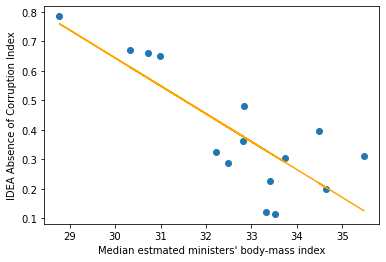

In [84]:
plot_filtered('IDEA absence of corruption', 'IDEA Absence of Corruption Index')


In [85]:
regress_filtered('Index of public integrity')

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=11
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                               
=====================================================================================
Dep. Variable:     Index of public integrity   R-squared:                       0.850
Model:                                   OLS   Adj. R-squared:                  0.833
Method:                        Least Squares   F-statistic:                     50.98
Date:                       Tue, 22 Feb 2022   Prob (F-statistic):           5.43e-05
Time:                               16:34:37   Log-Likelihood:                -6.7101
No. Observations:                         11   AIC:                             17.42
Df Residuals:                              9   BIC:                             18.22
Df Model:                                  1                                         
Covariance Type:                   nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.7536      2.835      9.437      0.000      20.341      33.166
median_bmi    -0.6270      0.088     -7.140      0.000      -0.826      -0.428
==============================================================================
Omnibus:                        0.044   Durbin-Watson:                   1.873
Prob(Omnibus):                  0.978   Jarque-Bera (JB):                0.127
Skew:                          -0.052   Prob(JB):                        0.939
Kurtosis:                       2.484   Cond. No.                         617.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

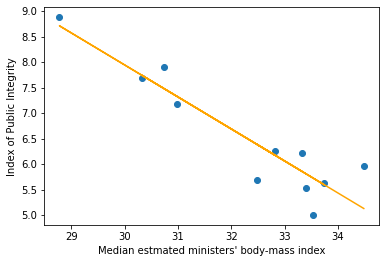

In [86]:
plot_filtered('Index of public integrity', 'Index of Public Integrity')

# Test for difference between women in gov and not

In [87]:
# bmi_with_ministers
mean_f_minister_bmi = estimated_ministers[ministers.sex == 'F'].groupby('country').mean().estimated_bmi
mean_f_bmi = bmi['2016Female']
mean_f_bmi.drop('Azerbaijan', inplace=True) # Azerbaijan has no female ministers

mean_f_bmi.index = mean_f_minister_bmi.index
f_bmi_comparison = pd.concat([mean_f_minister_bmi, bmi['2016Female']], axis=1, sort=True)
f_bmi_comparison


,estimated_bmi,2016Female
Armenia,27.363757,27.5
Azerbaijan,NaN,27.9
Belarus,34.877650,27.7
Estonia,27.803549,26.8
Georgia,28.248496,28.4
Kazakhstan,30.817848,26.6
Kyrgyzstan,31.498928,26.8
Latvia,28.240949,27.5
Lithuania,27.678877,26.8
Moldova,32.197474,28.0


# Building Standardized BMI

In [ ]:
# get data from (non-comitted) .sav files from the Health in Times of Transition 2010 survey
# takes a while to run
hitt1 = pd.read_spss('./Data/EAB_2_26 10 14.sav')

hitt1_country_abbr = hitt1['COUNTRIES']
hitt1_sex = hitt1['V010']
hitt1_age = hitt1['V011']
hitt1_height = hitt1['V024']
hitt1_weight = hitt1['V025']

hitt1_trimmed = pd.concat([
    hitt1_country_abbr,
    hitt1_sex,
    hitt1_age,
    pd.to_numeric(hitt1_height),
    pd.to_numeric(hitt1_weight),
], axis=1)

hitt1_trimmed.rename(columns={
    'COUNTRIES': 'country',
    'V010': 'sex',
    'V011': 'age',
    'V024': 'height',
    'V025': 'weight'
}, inplace=True)

# formula from https://www.cdc.gov/nccdphp/dnpao/growthcharts/training/bmiage/page5_1.html
hitt1_trimmed['bmi'] = (
    (hitt1_trimmed['weight'] / (hitt1_trimmed['height']**2)) * 10000).round(1)
hitt1_trimmed.drop(['height', 'weight'], axis=1, inplace=True)

abbrv_transform = {
    'MD': 'Moldova',
    'BY': 'Belarus',
    'RU': 'Russia',
    'KG': 'Kyrgyzstan',
    'KZ': 'Kazakhstan',
    'UA': 'Ukraine',
    'AM': 'Armenia',
    'GE': 'Georgia',
    'AZ': 'Azerbaijan'
}

hitt1_trimmed['country'] = hitt1_trimmed.replace({'country': abbrv_transform})
hitt1_trimmed.to_csv('./Data/hitt_trimmed.csv')


In [88]:
# uses saved cleaned data from above
hitt = pd.read_csv('./Data/hitt_trimmed.csv')
# remove missing data
print(hitt.shape)
hitt = hitt.dropna()
print(hitt.shape)
hitt.head()

(18000, 5)
(16943, 5)


,Unnamed: 0,country,sex,age,bmi
0,0,Moldova,Female,51.0,33.5
1,1,Moldova,Female,82.0,20.0
2,2,Moldova,Male,50.0,24.7
3,3,Moldova,Female,42.0,22.8
4,4,Moldova,Female,37.0,23.9


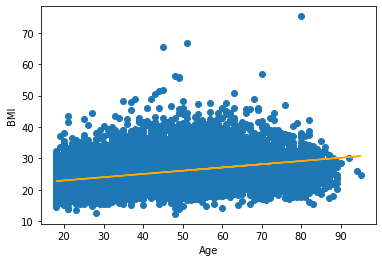

In [89]:
simple_scatter(hitt['age'], hitt['bmi'], 'Age', 'BMI')


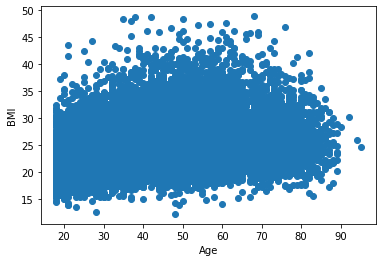

In [90]:
# removal of outliers: BMI > 50
hitt = hitt[hitt['bmi'] < 50]
simple_scatter(hitt['age'], hitt['bmi'], 'Age', 'BMI', regression_line=False)


Text(0.5, 0, 'Age')

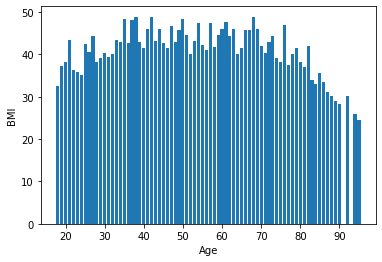

In [91]:
plt.bar(hitt['age'], height=hitt['bmi'])  # density=False would make counts
plt.ylabel('BMI')
plt.xlabel('Age')


In [92]:
# transforms sex into numerical binary variable
hitt['is_female'] = (hitt['sex'] == 'Female').astype(int)
hitt['agesex'] = hitt['is_female'] * hitt['age']
for el in ['bmi','age', 'is_female']:
    print(hitt[el].size)

16932
16932
16932


In [93]:
# first regression: BMI on age and sex
age_sex_X = [hitt['age'], hitt['is_female']]
age_sex_X = sm.add_constant(age_sex_X)
age_sex_regress = sm.OLS.from_formula(formula='bmi ~ age + is_female', data=hitt).fit()
age_sex_regress.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.139
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     1371.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:24:43   Log-Likelihood:                -48876.
No. Observations:               16932   AIC:                         9.776e+04
Df Residuals:                   16929   BIC:                         9.778e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.0016      0.095    220.761      0.000      20.815      21.188
age            0.1027      0.002     52.350      0.000       0.099       0.107
is_female     -0.1625      0.067     -2.413      0.016      -0.294      -0.031
==============================================================================
Omnibus:                     2099.811   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3594.616
Skew:                           0.843   Prob(JB):                         0.00
Kurtosis:                       4.501   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
# second regression: BMI on age, sex, and interaction
age_sex_regress2 = sm.OLS.from_formula(
    formula='bmi ~ age + is_female + agesex', data=hitt).fit()
age_sex_regress2.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    bmi   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     1016.
Date:                Tue, 22 Feb 2022   Prob (F-statistic):               0.00
Time:                        17:25:08   Log-Likelihood:                -48745.
No. Observations:               16932   AIC:                         9.750e+04
Df Residuals:                   16928   BIC:                         9.753e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.4879      0.131    171.080      0.000      22.230      22.746
age            0.0666      0.003     22.554      0.000       0.061       0.072
is_female     -2.8530      0.179    -15.979      0.000      -3.203      -2.503
agesex         0.0638      0.004     16.249      0.000       0.056       0.072
==============================================================================
Omnibus:                     2124.635   Durbin-Watson:                   1.918
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3754.217
Skew:                           0.838   Prob(JB):                         0.00
Kurtosis:                       4.585   Cond. No.                         342.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [95]:
# prepare minister data for regression estimation
estimated_ministers_wot = estimated_ministers[estimated_ministers['country'] != 'Tajikistan']
print(estimated_ministers_wot.shape)
estimated_ministers_trimmed = estimated_ministers_wot[~np.isnan(estimated_ministers_wot.age)]
estimated_ministers_trimmed = estimated_ministers_trimmed[~np.isnan(estimated_ministers_trimmed.age)]

estimated_ministers_trimmed['is_female'] = (estimated_ministers_trimmed['sex'] == 'F').astype(int)
estimated_ministers_trimmed['agesex'] = estimated_ministers_trimmed['is_female'] * estimated_ministers_trimmed['age']


(281, 6)


In [96]:
# first regression on just age and sex

def first_regression(row) -> int:
    age = row.age
    is_female = row.is_female
    return age_sex_regress.params.Intercept + (age_sex_regress.params.age * age) + (age_sex_regress.params.is_female * is_female)


ministers_results = estimated_ministers_trimmed
ministers_results['first_reg'] = ministers_results.apply(
    first_regression, axis=1)

ministers_results


,name,age,sex,country,image,estimated_bmi,is_female,agesex,first_reg
0,Karen Karapetyan,53.0,M,Armenia,45bbf60d9a78c802.jpg,32.211291,0,0.0,26.446803
1,Vigen Sargsyan,42.0,M,Armenia,7cd0c6d7bb93035.jpg,35.059298,0,0.0,25.316676
2,Vache Gabrielyan,48.0,M,Armenia,ac879073ab927981.jpg,36.977683,0,0.0,25.933109
3,Suren Karayan,44.0,M,Armenia,a2ba3f513063c0b.jpg,31.083077,0,0.0,25.522153
4,Ignati Arakelyan,45.0,M,Armenia,8676f84b0cbeec53.jpg,30.664515,0,0.0,25.624892
...,...,...,...,...,...,...,...,...,...
292,Alisher Shadmanov,55.0,M,Uzbekistan,99a824bb6e9d4bed.jpg,29.219586,0,0.0,26.652281
293,Ibrohim Abdurahmonov,42.0,M,Uzbekistan,3bd298a016c94ea2.jpg,35.764785,0,0.0,25.316676
294,Abdulaziz Kamilov,69.0,M,Uzbekistan,60f67441029210ab.jpg,39.321157,0,0.0,28.090625
296,Qobul Berdiyev,62.0,M,Uzbekistan,3b9850b3d6592a5.jpg,38.124117,0,0.0,27.371453


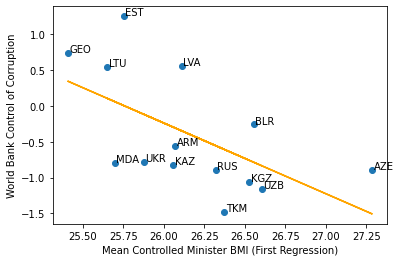

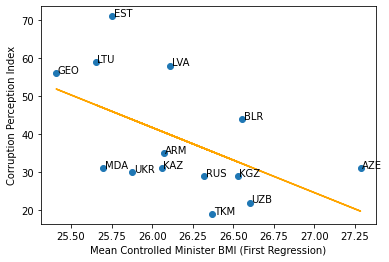

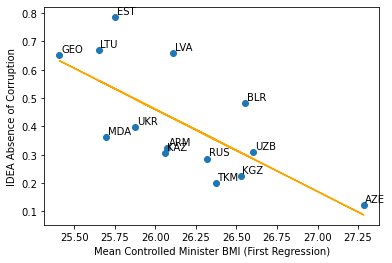

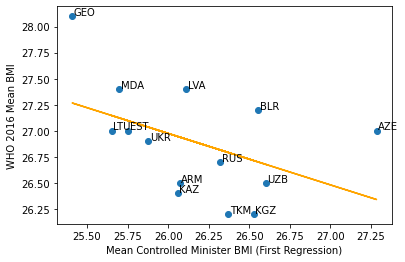

In [97]:
# check results of normalization against corruption measures
first_means = ministers_results.groupby('country').first_reg.mean()
corruption_minus_tajikstan = corruption.drop('Tajikistan')

def first_reg_scatter(measure, ylabel):
    annotate_scatter(
        first_means, 
        corruption_minus_tajikstan[measure], 
        abbrviate_countries(corruption_minus_tajikstan.index), 
        x_adjust=0.01, y_adjust=0.01, 
        xlabel="Mean Controlled Minister BMI (First Regression)", 
        ylabel=ylabel
        )


first_reg_scatter('control_of_corruption', "World Bank Control of Corruption")
first_reg_scatter('corruption perception index',
                  "Corruption Perception Index")
first_reg_scatter('IDEA absence of corruption',
                  "IDEA Absence of Corruption")

bmi_means_2016 = bmi['2016Both sexes'].drop('Tajikistan')

annotate_scatter(
    first_means,
    bmi_means_2016,
    abbrviate_countries(first_means.index),
    0.01, 0.01,
    'Mean Controlled Minister BMI (First Regression)',
    'WHO 2016 Mean BMI'
)


In [98]:
regress(corruption_minus_tajikstan['control_of_corruption'], first_means).summary()

/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.338
Model:                               OLS   Adj. R-squared:                  0.283
Method:                    Least Squares   F-statistic:                     6.125
Date:                   Tue, 22 Feb 2022   Prob (F-statistic):             0.0292
Time:                           17:26:21   Log-Likelihood:                -13.896
No. Observations:                     14   AIC:                             31.79
Df Residuals:                         12   BIC:                             33.07
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.4105     10.431      2.436      0.031       2.682      48.139
first_reg     -0.9865      0.399     -2.475      0.029      -1.855      -0.118
==============================================================================
Omnibus:                        1.567   Durbin-Watson:                   1.170
Prob(Omnibus):                  0.457   Jarque-Bera (JB):                1.005
Skew:                           0.349   Prob(JB):                        0.605
Kurtosis:                       1.889   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [99]:
regress(
    corruption_minus_tajikstan['corruption perception index'], first_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.280
Model:                                     OLS   Adj. R-squared:                  0.220
Method:                          Least Squares   F-statistic:                     4.663
Date:                         Tue, 22 Feb 2022   Prob (F-statistic):             0.0518
Time:                                 17:26:26   Log-Likelihood:                -55.757
No. Observations:                           14   AIC:                             115.5
Df Residuals:                               12   BIC:                             116.8
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        486.7947    207.444      2.347      0.037      34.813     938.776
first_reg    -17.1180      7.927     -2.159      0.052     -34.391       0.154
==============================================================================
Omnibus:                        1.823   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.402   Jarque-Bera (JB):                1.145
Skew:                           0.420   Prob(JB):                        0.564
Kurtosis:                       1.879   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [100]:
regress(corruption_minus_tajikstan['IDEA absence of corruption'], first_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.486
Model:                                    OLS   Adj. R-squared:                  0.443
Method:                         Least Squares   F-statistic:                     11.35
Date:                        Tue, 22 Feb 2022   Prob (F-statistic):            0.00558
Time:                                17:26:28   Log-Likelihood:                 7.5556
No. Observations:                          14   AIC:                            -11.11
Df Residuals:                              12   BIC:                            -9.833
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.0047      2.254      3.552      0.004       3.094      12.915
first_reg     -0.2902      0.086     -3.369      0.006      -0.478      -0.103
==============================================================================
Omnibus:                        1.867   Durbin-Watson:                   1.314
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                1.265
Skew:                           0.509   Prob(JB):                        0.531
Kurtosis:                       1.936   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [101]:
regress(bmi_means_2016, first_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         2016Both sexes   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     3.180
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0998
Time:                        17:26:31   Log-Likelihood:                -8.8077
No. Observations:                  14   AIC:                             21.62
Df Residuals:                      12   BIC:                             22.89
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.8252      7.253      5.491      0.000      24.023      55.627
first_reg     -0.4943      0.277     -1.783      0.100      -1.098       0.110
==============================================================================
Omnibus:                        1.791   Durbin-Watson:                   2.255
Prob(Omnibus):                  0.408   Jarque-Bera (JB):                1.118
Skew:                           0.403   Prob(JB):                        0.572
Kurtosis:                       1.875   Cond. No.                     1.45e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.45e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [103]:
# second regression on age, sex, age^2, age*sex, and age^2*sex
def second_regression(row) -> int:
    return age_sex_regress2.params.Intercept + (age_sex_regress2.params.is_female * row.is_female) + (age_sex_regress2.params.age * row.age) + (age_sex_regress2.params.agesex * row.agesex)

    
ministers_results['second_reg'] = ministers_results.apply(
    second_regression, axis=1)

ministers_results


,name,age,sex,country,image,estimated_bmi,is_female,agesex,first_reg,second_reg
0,Karen Karapetyan,53.0,M,Armenia,45bbf60d9a78c802.jpg,32.211291,0,0.0,26.446803,26.019662
1,Vigen Sargsyan,42.0,M,Armenia,7cd0c6d7bb93035.jpg,35.059298,0,0.0,25.316676,25.286661
2,Vache Gabrielyan,48.0,M,Armenia,ac879073ab927981.jpg,36.977683,0,0.0,25.933109,25.686480
3,Suren Karayan,44.0,M,Armenia,a2ba3f513063c0b.jpg,31.083077,0,0.0,25.522153,25.419934
4,Ignati Arakelyan,45.0,M,Armenia,8676f84b0cbeec53.jpg,30.664515,0,0.0,25.624892,25.486571
...,...,...,...,...,...,...,...,...,...,...
292,Alisher Shadmanov,55.0,M,Uzbekistan,99a824bb6e9d4bed.jpg,29.219586,0,0.0,26.652281,26.152935
293,Ibrohim Abdurahmonov,42.0,M,Uzbekistan,3bd298a016c94ea2.jpg,35.764785,0,0.0,25.316676,25.286661
294,Abdulaziz Kamilov,69.0,M,Uzbekistan,60f67441029210ab.jpg,39.321157,0,0.0,28.090625,27.085846
296,Qobul Berdiyev,62.0,M,Uzbekistan,3b9850b3d6592a5.jpg,38.124117,0,0.0,27.371453,26.619390


Text(0, 0.5, 'Controlled BMI (Second Regression)')

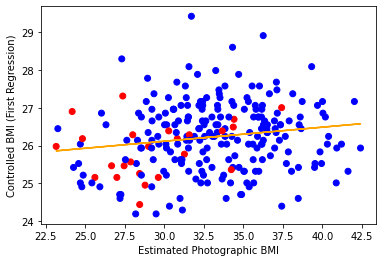

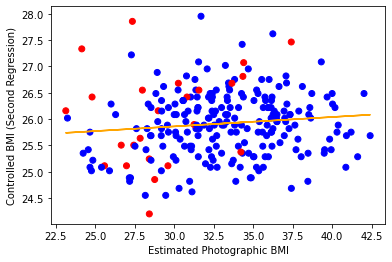

In [104]:
# graph estimated BMI against regressed BMI
# simple_scatter(ministers_results.estimated_bmi, ministers_results.first_reg, 'Estimated Photographic BMI', 'Controlled BMI (First Regression)', 'Estimated BMI and First Regression Results')
# simple_scatter(ministers_results.estimated_bmi, ministers_results.second_reg, 'Estimated Photographic BMI', 'Controlled BMI (Second Regression)', 'Estimated BMI and Second Regression Results')

fig1, ax1 = plt.subplots()
colors={0: 'blue', 1: 'red'}

ax1.scatter(ministers_results.estimated_bmi, ministers_results.first_reg, c=ministers_results.is_female.map(colors))
ax1.set_xlabel('Estimated Photographic BMI')
ax1.set_ylabel('Controlled BMI (First Regression)')
m1, b1 = np.polyfit(ministers_results.estimated_bmi,
                  ministers_results.first_reg, 1)
ax1.plot(ministers_results.estimated_bmi, m1 *
         ministers_results.estimated_bmi+b1, color='orange')

fig1, ax2 = plt.subplots()

ax2.scatter(ministers_results.estimated_bmi,
            ministers_results.second_reg, c=ministers_results.is_female.map(colors))
m2, b2 = np.polyfit(ministers_results.estimated_bmi,
                  ministers_results.second_reg, 1)
ax2.plot(ministers_results.estimated_bmi, m2 *
         ministers_results.estimated_bmi+b2, color='orange')
ax2.set_xlabel('Estimated Photographic BMI')
ax2.set_ylabel('Controlled BMI (Second Regression)')


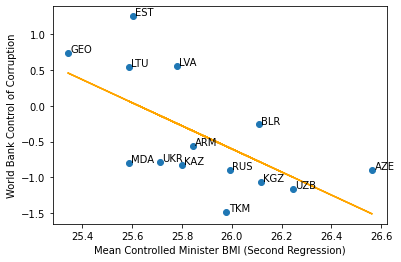

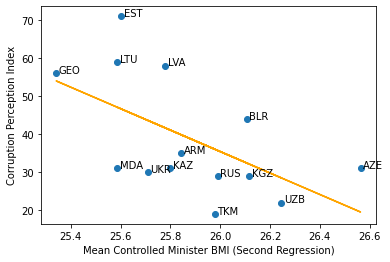

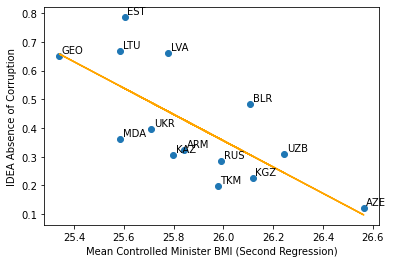

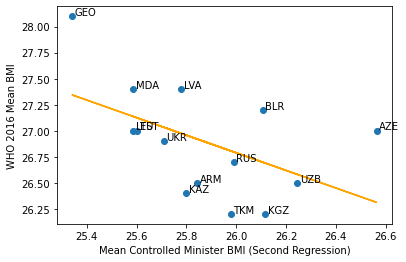

In [105]:
second_means = ministers_results.groupby('country').second_reg.mean()
corruption_minus_tajikstan = corruption.drop('Tajikistan')


def second_reg_scatter(measure, ylabel):
    annotate_scatter(
        second_means,
        corruption_minus_tajikstan[measure],
        abbrviate_countries(corruption_minus_tajikstan.index),
        x_adjust=0.01, y_adjust=0.01,
        xlabel="Mean Controlled Minister BMI (Second Regression)",
        ylabel=ylabel
    )


second_reg_scatter('control_of_corruption', "World Bank Control of Corruption")
second_reg_scatter('corruption perception index',
                  "Corruption Perception Index")
second_reg_scatter('IDEA absence of corruption',
                  "IDEA Absence of Corruption")

bmi_means_2016 = bmi['2016Both sexes'].drop('Tajikistan')

annotate_scatter(
    second_means,
    bmi_means_2016,
    abbrviate_countries(first_means.index),
    0.01, 0.01,
    'Mean Controlled Minister BMI (Second Regression)',
    'WHO 2016 Mean BMI'
)


In [106]:
regress(
    corruption_minus_tajikstan['control_of_corruption'], second_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     control_of_corruption   R-squared:                       0.379
Model:                               OLS   Adj. R-squared:                  0.327
Method:                    Least Squares   F-statistic:                     7.315
Date:                   Tue, 22 Feb 2022   Prob (F-statistic):             0.0191
Time:                           17:31:39   Log-Likelihood:                -13.451
No. Observations:                     14   AIC:                             30.90
Df Residuals:                         12   BIC:                             32.18
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.2737     15.410      2.678      0.020       7.699      74.848
second_reg    -1.6106      0.596     -2.705      0.019      -2.908      -0.313
==============================================================================
Omnibus:                        1.048   Durbin-Watson:                   1.225
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                0.788
Skew:                           0.259   Prob(JB):                        0.674
Kurtosis:                       1.959   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [107]:
regress(
    corruption_minus_tajikstan['corruption perception index'], second_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:     corruption perception index   R-squared:                       0.320
Model:                                     OLS   Adj. R-squared:                  0.263
Method:                          Least Squares   F-statistic:                     5.636
Date:                         Tue, 22 Feb 2022   Prob (F-statistic):             0.0351
Time:                                 17:31:42   Log-Likelihood:                -55.359
No. Observations:                           14   AIC:                             114.7
Df Residuals:                               12   BIC:                             116.0
Df Model:                                    1                                         
Covariance Type:                     nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        768.8693    307.495      2.500      0.028      98.894    1438.844
second_reg   -28.2105     11.883     -2.374      0.035     -54.102      -2.319
==============================================================================
Omnibus:                        1.484   Durbin-Watson:                   1.151
Prob(Omnibus):                  0.476   Jarque-Bera (JB):                1.000
Skew:                           0.369   Prob(JB):                        0.606
Kurtosis:                       1.919   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [108]:
regress(
    corruption_minus_tajikstan['IDEA absence of corruption'], second_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                OLS Regression Results                                
======================================================================================
Dep. Variable:     IDEA absence of corruption   R-squared:                       0.510
Model:                                    OLS   Adj. R-squared:                  0.469
Method:                         Least Squares   F-statistic:                     12.50
Date:                        Tue, 22 Feb 2022   Prob (F-statistic):            0.00411
Time:                                17:31:44   Log-Likelihood:                 7.8910
No. Observations:                          14   AIC:                            -11.78
Df Residuals:                              12   BIC:                            -10.50
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.2741      3.355      3.658      0.003       4.963      19.585
second_reg    -0.4584      0.130     -3.535      0.004      -0.741      -0.176
==============================================================================
Omnibus:                        2.047   Durbin-Watson:                   1.360
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.189
Skew:                           0.410   Prob(JB):                        0.552
Kurtosis:                       1.832   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [109]:
regress(bmi_means_2016, second_means).summary()


/home/ldtcoop/miniconda3/envs/ussr/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         2016Both sexes   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     4.161
Date:                Tue, 22 Feb 2022   Prob (F-statistic):             0.0640
Time:                        17:31:47   Log-Likelihood:                -8.3696
No. Observations:                  14   AIC:                             20.74
Df Residuals:                      12   BIC:                             22.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.7572     10.720      4.548      0.001      25.401      72.113
second_reg    -0.8450      0.414     -2.040      0.064      -1.748       0.058
==============================================================================
Omnibus:                        1.666   Durbin-Watson:                   2.246
Prob(Omnibus):                  0.435   Jarque-Bera (JB):                1.009
Skew:                           0.326   Prob(JB):                        0.604
Kurtosis:                       1.858   Cond. No.                     2.19e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.19e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""